[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cyneuro/Borgers-Examples-in-BMTK/blob/main/29-Single_Inhib_Pulse/29_Single_Inhibitory_Pulse.ipynb)

# Chapter 29 - Approximate Synchronization by Single Inhibitory Pulse
#### by Matthew Stroud and Gregory Glickert

This notebook is a translation of an example in Christophe Borgers' book, "An Introduction to Modeling Neuronal Dynamics"

This example comes in 3 parts: 

1) 10 Splayed RTM neurons with regular firing

2) First set-up but with an inhibitory pulse that is weak with long time constant

3) First set-up but with an inhibitory pulse that is strong with short time constant

Bold sections are labelled with a 1), 2), or 3) to help you keep track of where you are in the notebook.



requirements:

 bmtk

 NEURON 7.4+

# Part 1: Regular firing of RTM neurons

### 1) Create our 10 cell RTM network 

In [1]:
import os
from os.path import normpath, sep, join

RunningInCOLAB = 'google.colab' in str(get_ipython()) 
if RunningInCOLAB:  
  %pip install neuron==8.2.4 &> /dev/null
  %pip install bmtk &> /dev/null

  root = 'Borgers-Examples-in-BMTK' # name of github repo
  folder = '29-Single_Inhib_Pulse' # name of folder in Github just change this line 
  pathlist = normpath(os.getcwd()).split(sep)
  if pathlist[-1] != folder:
    rootidx = pathlist.index(root) if root in pathlist else -1
    if rootidx>0:
      os.chdir(join(sep,*pathlist[:rootidx]))
    !git clone https://github.com/Cyneuro/Borgers-Examples-in-BMTK
    os.chdir(join(root,folder))
    
print(os.system('nrnivmodl components/mechanisms')) # compile modfiles. Return 0 for success, 1 for failure.

/home/gjgpb9/Borgers-Examples-in-BMTK/29-Single_Inhib_Pulse
Mod files: "components/mechanisms/components/mechanisms/k_rtm.mod" "components/mechanisms/components/mechanisms/k_wb.mod" "components/mechanisms/components/mechanisms/leak.mod" "components/mechanisms/components/mechanisms/na_rtm.mod" "components/mechanisms/components/mechanisms/na_wb.mod" "components/mechanisms/components/mechanisms/vecevent.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special
0


/home/gjgpb9/miniconda3/envs/bmtk/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


In [2]:
import numpy as np
import logging
import math

from bmtk.builder.networks import NetworkBuilder

n_E =10

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

In [3]:
net.build()
net.save_nodes(output_dir='network')

### 1) Create an external network to change the initial voltage of each RTM cell

In [4]:
n_In=10
extnet = NetworkBuilder('extnet')
extnet.add_nodes(N=n_In,pop_name='Inp',
            potential='exc',
            model_type='virtual')

## 1) Function for voltage from node id

BMTK does not allow individual nodes to start with distinct initial voltages. This is exactly what we need. To accomplish this, we will add a unique synaptic input to all of our cells to create initial voltages.

First, we need an equation that will match a node id with the initial voltages in Borger's example. The initial voltages are given in the first vector. 

 init_volt=[-58.6290, -62.4873, -64.7941, -67.1735, -69.9618, -73.3491, -77.4968, -82.5814, -88.8151, -96.3579]

graphing and fitting a 4th order polynomial to this data yields the following equation:

      v = 0.0044675117*x**4 - 0.1256364996*x**3 + 0.7666447261*x**2 - 4.1554128011*x - 58.7232615386
    

## 1) Function for synaptic weight from desired initial voltages

After obtaining 10 data points of the resulting initial voltage to given synaptic weights, the following data was obtained:

Syn
-1.042198669
-0.484461009
-0.141396242
0
0.349858808
0.8221188
1.459603111
2.320116923
3.48168907
5.049647464
7.166169913
10.02317638
13.87973172

Voltage
-51.24979369
-61.37777297
-65.0976558
-66.04203933
-69.29723967
-73.30734354
-78.16310347
-83.87310562
-90.32510651
-97.25873706
-104.2704826
-110.8721422
-116.6017564




A 6th degree polynomial was fit to this data to yield the following equation: 

    syn_weight = 0.000000019395603*v**6 + 0.000008466808328*v**5 + 0.001546246691387*v**4 + 0.150852024612194*v**3 + 8.291209035520400*v**2 + 242.792603083843000*v + 2937.206029698790000


Using this equation, we can plug in our desired voltages derived from the first equation into this equation.

## 1) Add connections from our external network to our RTM cells

In [5]:
def one_each(source, target):
    if source['node_id']==target['node_id']:
        return 1
    return 0

def set_syn_weight(source, target):
    sec_x = 0.5
    sec_id = 0
    x=target['node_id']
    a=1
    v = 0.0044675117*x**4 - 0.1256364996*x**3 + 0.7666447261*x**2 - 4.1554128011*x - 58.7232615386
    syn_weight = 0.000000019395603*v**6 + 0.000008466808328*v**5 + 0.001546246691387*v**4 + 0.150852024612194*v**3 + 8.291209035520400*v**2 + 242.792603083843000*v + 2937.206029698790000
    #syn_weight = math.exp(target['node_id']*(0.5))-1
    #print(target['node_id'])
    #print(v)
    print(syn_weight)
    return syn_weight, sec_x, sec_id

conn=extnet.add_edges(source={'pop_name':'Inp'}, target=net.nodes(),
                    connection_rule=one_each,              
                    delay=0,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.00000000001],
                    dynamics_params='Voltage_Set.json',
                    model_template='Exp2Syn')

conn.add_properties(['syn_weight','sec_x','sec_id'],
                    rule=set_syn_weight, 
                    dtypes=[float, np.uint, np.uint])

In [6]:
extnet.build()
extnet.save_nodes(output_dir='network')
extnet.save_edges(output_dir='network')

-6.472502449948479
-3.7829508190416163
-1.4752524583973354
0.7890113633902729
3.4696604722912525
7.088059843898918
12.295327520622777
20.06122493319981
32.2406885789087
53.75574294141825


### 1) Add a spike train to our external network (only at the beginning of the simulation)

In [7]:
from bmtk.utils.reports.spike_trains import SpikeTrains

spikes = SpikeTrains(population='extnet')
for i in range(10):
    spikes.add_spike(node_id=i,timestamp=0)
spikes.to_sonata('input/Splay.h5')

### 1) Add a current clamp
This current clamp will last the duration of the simulation with amplitude = 1.2 amp

In [8]:
import h5py


i_ext=[0]
for i in range(29):
    i_ext.append(1.2)

dts = [1]
gids = 'all'

#hf.close() # Uncomment this line temporarily if you receive 'file already open error'

hf = h5py.File("input/amps.h5", 'w')

hf.create_dataset("amplitudes", data=[i_ext])
hf.create_dataset("gids", data=gids)
hf.create_dataset("dts", data=dts)

hf.close()

### 1) Build the simulation environment

In [9]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                 network_dir='network',
                 tstop=30.0, dt=0.01,
                 report_vars=['v'],           # Record membrane potential and calcium (default soma)
                 spikes_inputs=[('extnet',    # Name of population which spikes will be generated for
                                'input/Splay.h5')],
                 #file_current_clamp={              
                      #"input_type": "file_current_clamp",
                      #"module": "FileIClamp",
                      #"input_file":"input/amps.h5",
                      #"node_set":"network"
                 #},
                  current_clamp={            # Creates a step current from 500.ms to 1500.0 ms
                    'amp': 0.600,
                    'delay': 0,
                    'duration': 30.0
                  },
                 v_init=-66.5,
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False,   # Will try to compile NEURON mechanisms
                 config_file='config.json',
                 overwrite_config=True
                )

### 1) Run the Simulation

In [10]:
from bmtk.simulator import bionet
from neuron import h

h.nrnmpi_init()
pc = h.ParallelContext()
conf = bionet.Config.from_json('config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

pc.barrier()
pc.gid_clear()
pc.done()

numprocs=1
2025-01-24 11:37:33,622 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


NEURON mechanisms not found in /home/gjgpb9/Borgers-Examples-in-BMTK/29-Single_Inhib_Pulse/components/mechanisms.
2025-01-24 11:37:33,701 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2025-01-24 11:37:33,707 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2025-01-24 11:37:33,708 [INFO] Building virtual cell stimulations for extnet_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for extnet_spikes


2025-01-24 11:37:33,728 [INFO] Running simulation for 30.000 ms with the time step 0.010 ms


INFO:NEURONIOUtils:Running simulation for 30.000 ms with the time step 0.010 ms


2025-01-24 11:37:33,729 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2025-01-24 11:37:33,730 [INFO] Block save every 3000 steps


INFO:NEURONIOUtils:Block save every 3000 steps


2025-01-24 11:37:34,234 [INFO]     step:3000 t_sim:30.00 ms


INFO:NEURONIOUtils:    step:3000 t_sim:30.00 ms


2025-01-24 11:37:34,243 [INFO] Simulation completed in 0.5149 seconds 


INFO:NEURONIOUtils:Simulation completed in 0.5149 seconds 


0.0

### 1) Display the Results

In [11]:
from bmtk.utils.reports.compartment import CompartmentReport

pop_name = 'Exc'
report = CompartmentReport('output/v_report.h5', population='pop_name', mode='r')
v_trace=[]
for i in range(10):
    v_trace.append(report.data(population='network', node_id=i))
    print(v_trace[i][12])
time = np.arange(report.tstart(population='network'), report.tstop(population='network'), report.dt(population='network'))


[-58.6675829]
[-62.17962302]
[-64.85236539]
[-67.27241348]
[-69.92695649]
[-73.1976935]
[-77.35991101]
[-82.5709331]
[-88.88312872]
[-96.28757714]


The voltage at the beginning of the simulation is printed for each cell. These voltages make fairly well with our desired initial voltages with some discrepancy

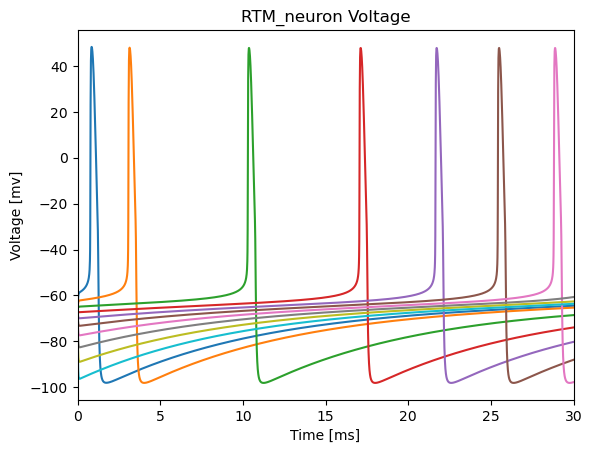

In [12]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.plot(time, v_trace[i])
plt.ylabel('Voltage [mv]')
plt.xlabel('Time [ms]')
plt.title('RTM_neuron Voltage')
plt.xlim([0,30])
#plt.ylim([-75,-65])
plt.show()

# If plot does not show run the cell again.

Besides some initial discrepancy, regular firing has been shown. 

The initial period is long and can be explained by our synaptic weight function to set the initial voltages for the different neurons. Our functions were derived from data points from previous runs not shown and fit into 4th an 6th order polynomials. Because these functions are approximations of other data, the initial conditions are slightly different than our desired set points. 

# Part 2: 

### 2) Add Inhibitory Pulse that is weak with long time constant

We must create a second network that copies features from the previous network and also adds an inhibitory spike

### 2) RTM Network (copied from previous simulation)

### 2) External Network(copied from previous simulation)

In [13]:
# remove old network 
import shutil
shutil.rmtree("network")
shutil.rmtree("input")

In [14]:
import numpy as np
import logging
import math

from bmtk.builder.networks import NetworkBuilder
n_E =10

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

In [15]:
net.build()
net.save_nodes(output_dir='network')

In [16]:
n_In=10
extnet = NetworkBuilder('extnet')
extnet.add_nodes(N=n_In,pop_name='Inp',
            potential='exc',
            model_type='virtual')

In [17]:
def one_each(source, target):
    if source['node_id']==target['node_id']:
        return 1
    return 0

def set_syn_weight(source, target):
    sec_x = 0.5
    sec_id = 0
    x=target['node_id']
    a=1
    v = 0.0044675117*x**4 - 0.1256364996*x**3 + 0.7666447261*x**2 - 4.1554128011*x - 58.7232615386
    syn_weight = 0.000000019395603*v**6 + 0.000008466808328*v**5 + 0.001546246691387*v**4 + 0.150852024612194*v**3 + 8.291209035520400*v**2 + 242.792603083843000*v + 2937.206029698790000
    #syn_weight = math.exp(target['node_id']*(0.5))-1
    #print(target['node_id'])
    #print(v)
    print(syn_weight)
    return syn_weight, sec_x, sec_id

conn=extnet.add_edges(source={'pop_name':'Inp'}, target=net.nodes(),
                    connection_rule=one_each,              
                    delay=0,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.00000000001],
                    dynamics_params='Voltage_Set.json',
                    model_template='Exp2Syn')

conn.add_properties(['syn_weight','sec_x','sec_id'],
                    rule=set_syn_weight, 
                    dtypes=[float, np.uint, np.uint])

In [18]:
extnet.build()
extnet.save_nodes(output_dir='network')
extnet.save_edges(output_dir='network')

-6.472502449948479
-3.7829508190416163
-1.4752524583973354
0.7890113633902729
3.4696604722912525
7.088059843898918
12.295327520622777
20.06122493319981
32.2406885789087
53.75574294141825


### Initial voltage set

In [19]:
from bmtk.utils.reports.spike_trains import SpikeTrains

spikes = SpikeTrains(population='extnet')
for i in range(10):
    spikes.add_spike(node_id=i,timestamp=0)
spikes.to_sonata('input/Splay.h5')

### 2) Current Clamp (same as before)

In [20]:
import h5py


i_ext=[0]
for i in range(29):
    i_ext.append(1.2)

dts = [1]
gids = 'all'

#hf.close() # Uncomment this line temporarily if you receive 'file already open error'

hf = h5py.File("input/amps.h5", 'w')

hf.create_dataset("amplitudes", data=[i_ext])
hf.create_dataset("gids", data=gids)
hf.create_dataset("dts", data=dts)

hf.close()

# 2) Add Inhibitory Pulse #1
This pulse is meant to go to all RTM neurons at the same time and only once. The pulse is supposed to be weighed weakly with long time constant.

#### 2) First create a second external network "inhib" to give each RTM neuron a single pulse

In [21]:
n_In=10
inhib = NetworkBuilder('inhib')
inhib.add_nodes(N=n_In,pop_name='Inp_inh',
            potential='inh',
            model_type='virtual')

The dynamic parameters of the synaptic pulse are set in "Weak_Long.json" where tau1 = 9 ms and tau2 = 0.1 ms. g_syn = 0.3 mS/cm^2

In [22]:
inhib.add_edges(source={'pop_name':'Inp_inh'}, target=net.nodes(),
                    connection_rule=one_each,              
                    delay=0,
                    syn_weight = 0.3,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 1.0],
                    dynamics_params='Weak_Long.json',
                    model_template='expsyn')

In [23]:
inhib.build()
inhib.save_nodes(output_dir='network')
inhib.save_edges(output_dir='network')

#### 2) Give spike to all inhib neurons 

In [24]:
from bmtk.utils.reports.spike_trains import SpikeTrains

spikes = SpikeTrains(population='inhib')
for i in range(10):
    spikes.add_spike(node_id=i,timestamp=0.2)
spikes.to_sonata('input/Inhib.h5')

## 2) Set up the simulation environment

In [25]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                 network_dir='network',
                 tstop=30.0, dt=0.01,
                 report_vars=['v'],           # Record membrane potential and calcium (default soma)
                 spikes_inputs=[('extnet',    # Name of population which spikes will be generated for
                                'input/Splay.h5'),('inhib', 'input/Inhib.h5')],
                 #file_current_clamp={              # Creates a step current from 500.ms to 1500.0 ms
                      #"input_type": "file_current_clamp",
                      #"module": "FileIClamp",
                      #"input_file":"input/amps.h5",
                      #"node_set":"network"
                 #},
                 current_clamp={            # Creates a step current from 500.ms to 1500.0 ms
                    'amp': 0.400,
                    'delay': 0,
                    'duration': 30.0
                  },
                 v_init=-66.5,
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False,   # Will try to compile NEURON mechanisms
                 config_file='config.json',
                 overwrite_config=True
                )

## 2) Run the Simulation

In [26]:
from bmtk.simulator import bionet

h.nrnmpi_init()
pc = h.ParallelContext()
conf = bionet.Config.from_json('config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

pc.barrier()
pc.gid_clear()
pc.done()

2025-01-24 11:37:34,952 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


NEURON mechanisms not found in /home/gjgpb9/Borgers-Examples-in-BMTK/29-Single_Inhib_Pulse/components/mechanisms.
2025-01-24 11:37:34,984 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2025-01-24 11:37:34,991 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2025-01-24 11:37:34,992 [INFO] Building virtual cell stimulations for extnet_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for extnet_spikes


2025-01-24 11:37:35,004 [INFO] Building virtual cell stimulations for inhib_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for inhib_spikes


2025-01-24 11:37:35,024 [INFO] Running simulation for 30.000 ms with the time step 0.010 ms


INFO:NEURONIOUtils:Running simulation for 30.000 ms with the time step 0.010 ms


2025-01-24 11:37:35,025 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2025-01-24 11:37:35,026 [INFO] Block save every 3000 steps


INFO:NEURONIOUtils:Block save every 3000 steps


2025-01-24 11:37:35,547 [INFO]     step:3000 t_sim:30.00 ms


INFO:NEURONIOUtils:    step:3000 t_sim:30.00 ms


2025-01-24 11:37:35,555 [INFO] Simulation completed in 0.5313 seconds 


INFO:NEURONIOUtils:Simulation completed in 0.5313 seconds 


0.0

## 2) Display the Results

In [27]:
from bmtk.utils.reports.compartment import CompartmentReport

pop_name = 'Exc'
report = CompartmentReport('output/v_report.h5',
population=pop_name, mode='r')
v_trace=[]
for i in range(10):
    v_trace.append(report.data(population='network', node_id=i))
    print(v_trace[i][5])
time = np.arange(report.tstart(population='network'), report.tstop(population='network'), report.dt(population='network'))

[-59.9150735]
[-62.79394074]
[-65.09066245]
[-67.20693151]
[-69.55295302]
[-72.47141886]
[-76.22823375]
[-81.00754341]
[-86.93809784]
[-94.17675856]


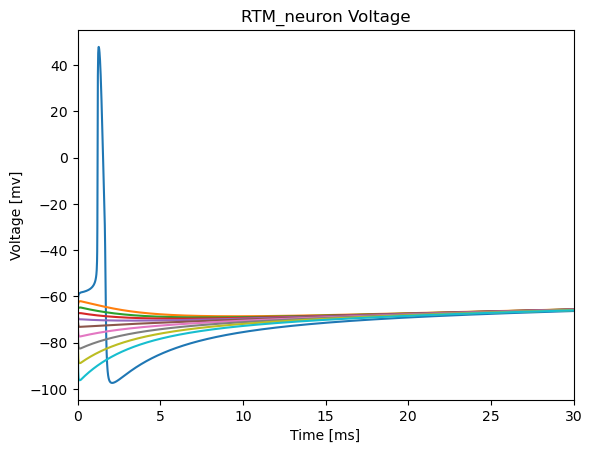

In [28]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.plot(time, v_trace[i])
plt.ylabel('Voltage [mv]')
plt.xlabel('Time [ms]')
plt.title('RTM_neuron Voltage')
plt.xlim([0,30])
#plt.ylim([-70,-65])
plt.show()

# If plot does not show run the cell again.

The single inhibitory pulse with a synaptic weight of 0.3 mS/cm^2 and tau1:0.1 ms tau2:9 ms will cause the unconnected RTM neurons to synchronize. 

As you can see, the first neuron fired at about the same time as without the inhibitory spike. This is because it's initial condition is so close to threshold the neuron was poised to spike. 

The other neurons less influenced by initial conditions synchronized.

# Part 3:
A third simulation can be performed that shows an inhibitory synapse with strong synaptic weight but short time constant. Again the single inhibitory pulse can cause the unconnected RTM neurons to synchronize.

First we copy our original network from Part 1:

In [29]:
# remove old network 
import shutil
shutil.rmtree("network")
shutil.rmtree("input")

In [30]:
import numpy as np
import logging
import math

from bmtk.builder.networks import NetworkBuilder

n_E =10

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

In [31]:
net.build()
net.save_nodes(output_dir='network')

In [32]:
n_In=10
extnet = NetworkBuilder('extnet')
extnet.add_nodes(N=n_In,pop_name='Inp',
            potential='exc',
            model_type='virtual')

In [ ]:
def one_each(source, target):
    if source['node_id']==target['node_id']:
        return 1
    return 0

def set_syn_weight(source, target):
    sec_x = 0.5
    sec_id = 0
    x=target['node_id']
    a=1
    v = 0.0044675117*x**4 - 0.1256364996*x**3 + 0.7666447261*x**2 - 4.1554128011*x - 58.7232615386
    syn_weight = 0.000000019395603*v**6 + 0.000008466808328*v**5 + 0.001546246691387*v**4 + 0.150852024612194*v**3 + 8.291209035520400*v**2 + 242.792603083843000*v + 2937.206029698790000
    #syn_weight = math.exp(target['node_id']*(0.5))-1
    #print(target['node_id'])
    #print(v)
    print(syn_weight)
    return syn_weight, sec_x, sec_id

conn=extnet.add_edges(source={'pop_name':'Inp'}, target=net.nodes(),
                    connection_rule=one_each,              
                    delay=0,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.00000000001],
                    dynamics_params='Voltage_Set.json',
                    model_template='Exp2Syn')

conn.add_properties(['syn_weight','sec_x','sec_id'],
                    rule=set_syn_weight, 
                    dtypes=[float, np.uint, np.uint])

In [34]:
extnet.build()
extnet.save_nodes(output_dir='network')
extnet.save_edges(output_dir='network')

-6.472502449948479
-3.7829508190416163
-1.4752524583973354
0.7890113633902729
3.4696604722912525
7.088059843898918
12.295327520622777
20.06122493319981
32.2406885789087
53.75574294141825


In [35]:
from bmtk.utils.reports.spike_trains import SpikeTrains

spikes = SpikeTrains(population='extnet')
for i in range(10):
    spikes.add_spike(node_id=i,timestamp=0)
spikes.to_sonata('input/Splay.h5')

### 3) Current Clamp

In [36]:
import h5py


i_ext=[0]
for i in range(29):
    i_ext.append(1.2)

dts = [1]
gids = 'all'

#hf.close() # Uncomment this line temporarily if you receive 'file already open error'

hf = h5py.File("input/amps.h5", 'w')

hf.create_dataset("amplitudes", data=[i_ext])
hf.create_dataset("gids", data=gids)
hf.create_dataset("dts", data=dts)

hf.close()

# 3) Add Inhibitory Pulse #2 

We add 10 neurons to give a single inhibitory spike into each cell of our network. We change the parameters of th.

In [37]:
n_In=10
inhib = NetworkBuilder('inhib')
inhib.add_nodes(N=n_In,pop_name='Inp_inh',
            potential='inh',
            model_type='virtual')

The dynamic parameters are set in "Strong_Short.json" which gives a tau1 of 1 ms and tau2 of 0.1 ms

In [38]:
inhib.add_edges(source={'pop_name':'Inp_inh'}, target=net.nodes(),
                    connection_rule=one_each,              
                    delay=0,
                    syn_weight = 2.25,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 1.0],
                    dynamics_params='Strong_Short.json',
                    model_template='expsyn')

Build and save our inhibitory neurons

In [39]:
inhib.build()
inhib.save_nodes(output_dir='network')
inhib.save_edges(output_dir='network')

#### Give 1 spike to the inhibitory neurons that feed into our network

In [40]:
from bmtk.utils.reports.spike_trains import SpikeTrains

spikes = SpikeTrains(population='inhib')
for i in range(10):
    spikes.add_spike(node_id=i,timestamp=0.2)
spikes.to_sonata('input/Inhib.h5')

## 3) Setting up the Simulation Environment

In [ ]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                 network_dir='network',
                 tstop=30.0, dt=0.01,
                 report_vars=['v'],           # Record membrane potential and calcium (default soma)
                 spikes_inputs=[('extnet',    # Name of population which spikes will be generated for
                                'input/Splay.h5'), ('inhib', 'input/Inhib.h5')],
                 #file_current_clamp={              # Creates a step current from 500.ms to 1500.0 ms
                     # "input_type": "file_current_clamp",
                      #"module": "FileIClamp",
                     # "input_file":"input/amps.h5",
                      #"node_set":"network"
                # },
                 current_clamp={            # Creates a step current from 500.ms to 1500.0 ms
                    'amp': 0.400,
                    'delay': 0,
                    'duration': 30.0
                  },
                 v_init=-66.5,
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False,   # Will try to compile NEURON mechanisms
                 config_file='config.json',
                 overwrite_config=True
                )

## 3) Running the Simulation

In [42]:
from bmtk.simulator import bionet

h.nrnmpi_init()
pc = h.ParallelContext()
conf = bionet.Config.from_json('config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

pc.barrier()
pc.gid_clear()
pc.done()

2025-01-24 11:37:35,851 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


NEURON mechanisms not found in /home/gjgpb9/Borgers-Examples-in-BMTK/29-Single_Inhib_Pulse/components/mechanisms.
2025-01-24 11:37:35,881 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2025-01-24 11:37:35,888 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2025-01-24 11:37:35,890 [INFO] Building virtual cell stimulations for extnet_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for extnet_spikes


2025-01-24 11:37:35,902 [INFO] Building virtual cell stimulations for inhib_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for inhib_spikes


2025-01-24 11:37:35,921 [INFO] Running simulation for 30.000 ms with the time step 0.010 ms


INFO:NEURONIOUtils:Running simulation for 30.000 ms with the time step 0.010 ms


2025-01-24 11:37:35,922 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2025-01-24 11:37:35,923 [INFO] Block save every 3000 steps


INFO:NEURONIOUtils:Block save every 3000 steps


2025-01-24 11:37:36,491 [INFO]     step:3000 t_sim:30.00 ms


INFO:NEURONIOUtils:    step:3000 t_sim:30.00 ms


2025-01-24 11:37:36,496 [INFO] Simulation completed in 0.5744 seconds 


INFO:NEURONIOUtils:Simulation completed in 0.5744 seconds 


0.0

## 3) Displaying the Results

In [43]:
from bmtk.utils.reports.compartment import CompartmentReport

pop_name = 'Exc'
report = CompartmentReport('output/v_report.h5',
population=pop_name, mode='r')
v_trace=[]
for i in range(10):
    v_trace.append(report.data(population='network', node_id=i))
    print(v_trace[i][5])
time = np.arange(report.tstart(population='network'), report.tstop(population='network'), report.dt(population='network'))

[-59.9150735]
[-62.79394074]
[-65.09066245]
[-67.20693151]
[-69.55295302]
[-72.47141886]
[-76.22823375]
[-81.00754341]
[-86.93809784]
[-94.17675856]


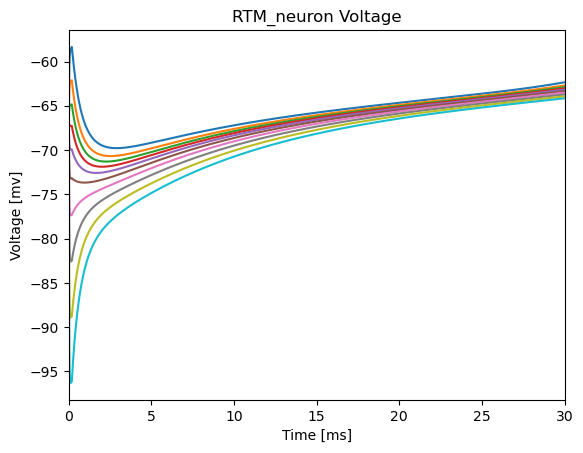

In [44]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.plot(time, v_trace[i])
plt.ylabel('Voltage [mv]')
plt.xlabel('Time [ms]')
plt.title('RTM_neuron Voltage')
plt.xlim([0,30])
#plt.ylim([-70,-65])
plt.show()


# If plot does not show run the cell again.

The strong inhibitory pulse with small time constant also is able to synchronize the unconnected RTM neurons.